# **Data Visualization Notebook**

## Objectives

* Answer business requirement 1:
    * The client is interesto in having a study to visually differentiate a healthy human brain MRI from the one with tumor

## Inputs

* The inputs consist of the images that are divided according to the following directory schema:

    ```
    input/
    ├── test
    │   ├── mri-non-tumor
    │   └── mri-tumor
    ├── train
    │   ├── mri-non-tumor
    │   └── mri-tumor
    └── validation
        ├── mri-non-tumor
        └── mri-tumor
    ```
## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between healthy brain MRI and the one with a tumor.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.


## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Set Data Directory

---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

# Set working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/home/tom/codeinstitute/brain-tumor-detect/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
working_dir = os.getcwd()
working_dir

'/home/tom/codeinstitute/brain-tumor-detect'

# Set Input Directories

Set train, validation and test paths.

In [5]:
input_dir = 'input'
train_path = os.path.join(input_dir, 'train')
test_path = os.path.join(input_dir, 'test')
validation_path = os.path.join(input_dir, 'validation')



In [6]:
version = 'v1'
file_path = os.path.join('outputs', version)

if 'outputs' in os.listdir(working_dir) and version in os.listdir(os.path.join(working_dir, 'outputs')):
    print('This version of the output dataset already exists.')
    pass
else:
    os.makedirs(name=file_path)

This version of the output dataset already exists.


# Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['mri-tumor', 'mri-non-tumor']


## Image Shape

Though the images are of the same shape, we should nevertheless compute the average image size of the train set.

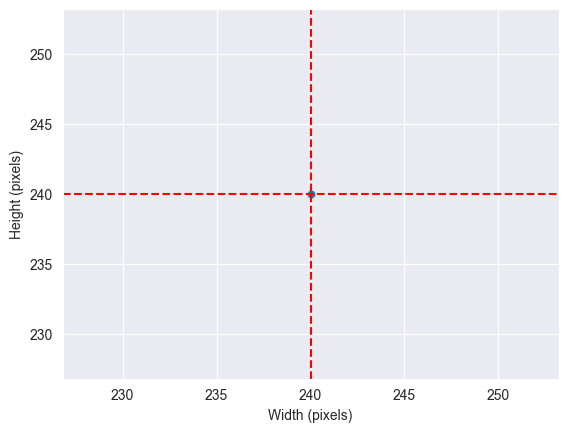

Width average: 240 
Height average: 240


In [8]:
# analyse image dimensions
image_height, image_width = [], []
for label in labels:
    for image_file in os.listdir(os.path.join(train_path, label)):
        image = imread(os.path.join(train_path, label, image_file))
        image_height.append(image.shape[0])
        image_width.append(image.shape[1])

# plot image dimension graph
sns.set_style("darkgrid")
fig, axes = plt.subplots()
sns.scatterplot(x=image_width, y=image_height, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
image_height_mean = int(np.array(image_height).mean())
image_width_mean = int(np.array(image_width).mean())
axes.axvline(x=image_height_mean, color='r', linestyle='--')
axes.axhline(y=image_width_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {image_width_mean} \nHeight average: {image_height_mean}")



As remarked before, all images have the same dimension, what is visible in this diagram.

In [9]:
image_shape = (image_height_mean, image_width_mean, 3)
image_shape

(240, 240, 3)

Save the image shape embeddings (will serve for the uploading a MRI brain scan that is not from the dataset)

In [10]:
joblib.dump(value=image_shape,
            filename=os.path.join(file_path, 'image_shape,pkl'))

['outputs/v1/image_shape,pkl']

---

# Average and varaiablity of images per label

## Load images in an array

In [18]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(data_dir)

    for label in labels:
        counter = 0
        for image_file in os.listdir(os.path.join(data_dir, label)):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(os.path.join(data_dir, label, image_file), target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


## Load image shapes and labels in an array

In [19]:
X, y = load_image_as_array(data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 240, 240, 3) (60,)


## Plot and save mean and variability of images per label

In [20]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label mri-non-tumor ====
Image Shape: (240, 240, 3)
==== Label mri-tumor ====
Image Shape: (240, 240, 3)


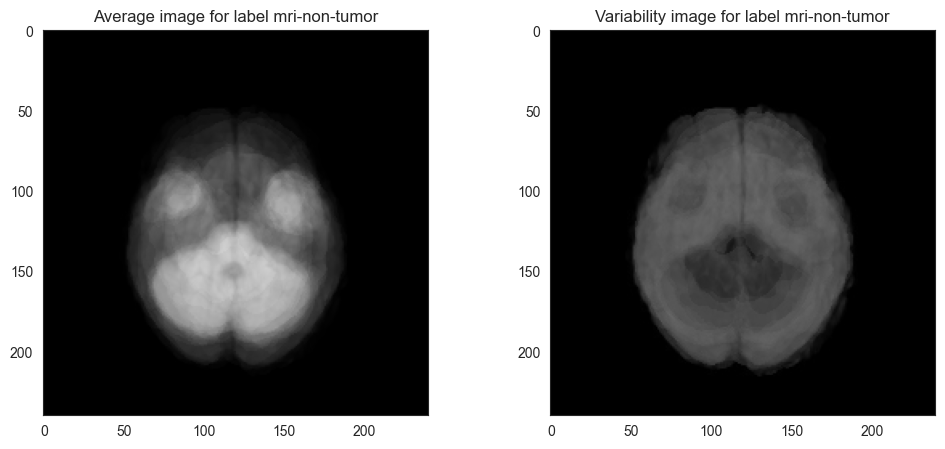

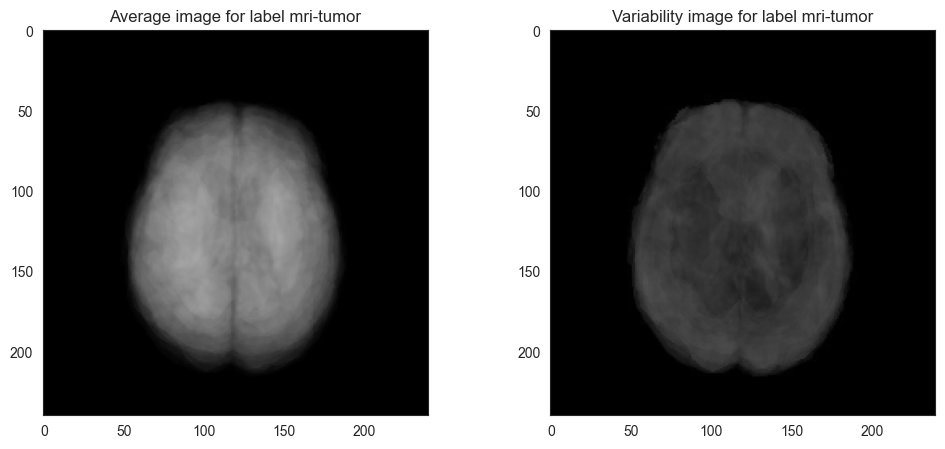

In [21]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)


---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


---

This code will be usefull when testing a MRI image that is not from the original dataset/